# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [1]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import sys
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import warnings
sys.setrecursionlimit(10000)

# Data manipulation
import numpy as np
from scipy.special import erf
from scipy.integrate import quad
import scipy.stats as stats
from scipy.signal import savgol_filter
from scipy.spatial import ConvexHull
from scipy.ndimage.filters import uniform_filter1d
from scipy.optimize import curve_fit

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec
from dyn_cond_fig_functions import *

# Clustering stuff
from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN, OPTICS
from sklearn.neighbors import KernelDensity
from itertools import cycle
# plt.cm.tab20.colors

# From alens_analysis.py
import alens_analysis as aa
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
from alens_analysis import cluster_analysis as cla

from alens_analysis.colormaps import register_cmaps

# Locations
ws_path = Path('/home/alamson/DATA/Chromatin/')
mnt_path = Path.home() / 'projects/DATA/Chromatin/'
ceph_path = Path.home() / 'ceph/DATA/Chromatin/'

### Style settings

In [2]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)

# colors = cycle(mcolors.XKCD_COLORS.keys())

register_cmaps()
plt.rcParams['image.cmap'] = 'YlOrRd'
        

In [3]:
def get_cluster_trees_from_h5file(h5_file, cluster_similarity_threshold = .4, nskip = 10, part_min = 0):
    clusters = []
    with h5py.File(h5_file, 'r') as h5_data:
        cluster_grp = h5_data['clusters']
        time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
        for tg in time_grp_list:
            clust_grp = [cla.Cluster(h5_data = c) for c in tg.values()]
            clust_grp = [clust for clust in clust_grp if len(clust.part_ids) > part_min]
            clusters += [clust_grp]

    root_clusters = cla.find_descendants(clusters, thresh=cluster_similarity_threshold, nskip=nskip)

    trees = []
    tree_id_gen = aa.helpers.gen_id()
    for root in root_clusters:
        tree = cla.ClusterTree(next(tree_id_gen))
        tree.add_recursive(root)
        trees += [tree]

    return trees

def get_lifetimes(branch_roots, min_time = 0, min_length = 0):
    lifetime_list = []
    for root in branch_roots:
        if root.time < min_time: # Skip if the root is too short
            continue
        l_branch = root.get_largest_branch()
        if len(l_branch) < min_length:
            continue
        lifetime_list += [l_branch[0].time-l_branch[-1].time]

    return lifetime_list

def get_time_of_events(branch_roots, min_time = 0, min_length = 0):
    eventime_list = []
    for root in branch_roots:
        if root.time < min_time: # Skip if the root is too short
            continue
        l_branch = root.get_largest_branch()
        if len(l_branch) < min_length:
            continue
        eventime_list += [l_branch[0].time]

    return eventime_list

def plot_branches(axarr, full_time_arr, branch_roots, window_size=10, color = 'tab:blue'):
    time_list = []
    base_color_hsv = mcolors.rgb_to_hsv(color)
    base_color_hsv[2] = .9  
    color_step = .8 / len(branch_roots)

    for i, root in enumerate(branch_roots):

        color_hsv = base_color_hsv.copy()
        color_hsv[2] = base_color_hsv[2] - (color_step*i) 
        branch_color = mcolors.hsv_to_rgb(color_hsv)

        l_branch = root.get_largest_branch()
        if len(l_branch) < 20:
            continue
        size_arr = np.zeros(len(l_branch))
        time_arr = np.zeros(len(l_branch))
        for j, clust in enumerate(l_branch):
            size_arr[j] = len(clust.part_ids)
            time_arr[j] = clust.time

        size_arr_smooth = uniform_filter1d(size_arr, size=window_size)
        _ = axarr.plot(time_arr, size_arr_smooth, linestyle='-', linewidth=2, color=branch_color)
        if i > 0:
            _ = axarr.scatter(time_arr[0], size_arr_smooth[0],  marker='o', linewidth=2, s=100, facecolor="none", edgecolor=branch_color)

        if root.time == full_time_arr[-1]: 
            print('Skipping root')
            # Skip, this is not a real event
            continue
        time_list += [time_arr[0]-time_arr[-1]]
    return time_list

def plot_cluster_size(axarr, full_time_arr, branch_roots, window_size=10, color = 'tab:blue', alpha=1):
    time_arr_list = []
    size_arr_list = []
    type_list = []

    for i, root in enumerate(branch_roots):


        l_branch = root.get_largest_branch()
        if len(l_branch) < 20:
            continue
        size_arr = np.zeros(len(l_branch))
        time_arr = np.zeros(len(l_branch))
        for j, clust in enumerate(l_branch):
            size_arr[j] = len(clust.part_ids)
            time_arr[j] = clust.time
        
        size_arr = size_arr[::-1]
        time_arr = time_arr[::-1]

        size_arr_smooth = uniform_filter1d(size_arr, size=window_size)
        _ = axarr.plot(time_arr, size_arr_smooth, linestyle='-', linewidth=2, color=color, alpha=alpha)

        if i > 0:
            _ = axarr.scatter(time_arr[-1], size_arr_smooth[-1],  marker='o', linewidth=2, s=100, facecolor="none", edgecolor=color)
            type_list.append('M')
        elif size_arr[-1] < 50:
            type_list.append('D')
        else:
            type_list.append('L')

        size_arr_list.append(size_arr)
        time_arr_list.append(time_arr)

    return time_arr_list, size_arr_list, type_list

def plot_large_cluster_sizes(axarr, full_time_arr, branch_roots, window_size=10, color = 'tab:blue', alpha=1):
    time_arr_list = []
    size_arr_list = []

    for i, root in enumerate(branch_roots):


        l_branch = root.get_largest_branch()
        if len(l_branch) < 20:
            continue
        size_arr = np.zeros(len(l_branch))
        time_arr = np.zeros(len(l_branch))
        for j, clust in enumerate(l_branch):
            size_arr[j] = len(clust.part_ids)
            time_arr[j] = clust.time

        size_arr_smooth = uniform_filter1d(size_arr, size=window_size)[::-1]
        time_arr = time_arr[::-1]
        if i > 0 or root.time < 3600 or size_arr_smooth[-1] < 300:
            continue
            # _ = axarr.scatter(time_arr[-1], size_arr_smooth[-1],  marker='o', linewidth=2, s=100, facecolor="none", edgecolor=color)

        _ = axarr.plot(time_arr, size_arr_smooth, linestyle='-', linewidth=2, color=color, alpha=alpha)

        size_arr_list.append(size_arr_smooth)
        time_arr_list.append(time_arr)

    return time_arr_list, size_arr_list

def plot_no_merge_cluster_sizes(axarr, full_time_arr, branch_roots, window_size=10, color = 'tab:blue', alpha=1):
    time_arr_list = []
    size_arr_list = []

    for i, root in enumerate(branch_roots):


        l_branch = root.get_largest_branch()
        if len(l_branch) < 20:
            continue
        size_arr = np.zeros(len(l_branch))
        time_arr = np.zeros(len(l_branch))
        for j, clust in enumerate(l_branch):
            size_arr[j] = len(clust.part_ids)
            time_arr[j] = clust.time

        size_arr_smooth = uniform_filter1d(size_arr, size=window_size)[::-1]
        time_arr = time_arr[::-1]
        if i > 0 :
            continue
            # _ = axarr.scatter(time_arr[-1], size_arr_smooth[-1],  marker='o', linewidth=2, s=100, facecolor="none", edgecolor=color)

        _ = axarr.plot(time_arr, size_arr_smooth, linestyle='-', linewidth=2, color=color, alpha=alpha)

        size_arr_list.append(size_arr_smooth)
        time_arr_list.append(time_arr)

    return time_arr_list, size_arr_list

def plot_no_dissolve_cluster_sizes(axarr, full_time_arr, branch_roots, window_size=10, color = 'tab:blue', alpha=1):
    time_arr_list = []
    size_arr_list = []

    for i, root in enumerate(branch_roots):


        l_branch = root.get_largest_branch()
        if len(l_branch) < 20:
            continue
        size_arr = np.zeros(len(l_branch))
        time_arr = np.zeros(len(l_branch))
        for j, clust in enumerate(l_branch):
            size_arr[j] = len(clust.part_ids)
            time_arr[j] = clust.time

        size_arr_smooth = uniform_filter1d(size_arr, size=window_size)[::-1]
        time_arr = time_arr[::-1]
        if size_arr_smooth[-1] < 50:
            continue
            # _ = axarr.scatter(time_arr[-1], size_arr_smooth[-1],  marker='o', linewidth=2, s=100, facecolor="none", edgecolor=color)

        _ = axarr.plot(time_arr, size_arr_smooth, linestyle='-', linewidth=2, color=color, alpha=alpha)

        size_arr_list.append(size_arr_smooth)
        time_arr_list.append(time_arr)

    return time_arr_list, size_arr_list

In [4]:

def plot_contact_kymo(fig, ax, time_arr, contact_kymo,
                      contact_type="", vmax=10, label_flag=True):
    y = np.arange(contact_kymo.shape[0] + 1)
    # Add extra time point
    x = np.append(time_arr, [time_arr[-1] + time_arr[2] - time_arr[1]])
    X, Y = np.meshgrid(x, y)
    c = ax.pcolorfast(X, Y, contact_kymo, vmax=vmax)
    divider = make_axes_locatable(ax)
    # Append axes to the right of ax, with 5% width of ax
    cax = divider.append_axes("top", size="5%", pad=0.05)

    cbar = fig.colorbar(c, cax=cax, label=r"Contact probability", orientation='horizontal', pad=0.1)
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')
    # cbar.ax.set_position([.1, 1.02, .8, .02])

    ax.set_ylabel("Bead index")


# Figure 5

In [11]:
!pvpython /mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/pv_snapshot_chromatin.py /mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-08_aLc1_slice5.5.13_line1600_Pin3-11um_2xKe3-300_ks100/simulations/Ke30_Pin5.0um/s2 2000
!cp /mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-08_aLc1_slice5.5.13_line1600_Pin3-11um_2xKe3-300_ks100/simulations/Ke30_Pin5.0um/s2/snapshot_chromatin_2000.png Figure5/Ke30_Pin5.0um_s2_2000.png

Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


<img width="50%" src="Figure5/Ke30_Pin5.0um_s2_2000.png?raw=true"></img>

(8401,)
[0.56823266 0.66222222 0.95      ]
Skipping root
Skipping root
[0.07814661 0.75607843 0.95      ]
Skipping root
Skipping root
[0.33333333 0.58       0.95      ]
[0.99904762 0.65420561 0.95      ]
[0.75387597 0.36402116 0.95      ]
[0.02820513 0.37142857 0.95      ]
[0.88425926 0.38061674 0.95      ]
[0.   0.   0.95]
[0.16774194 0.65608466 0.95      ]


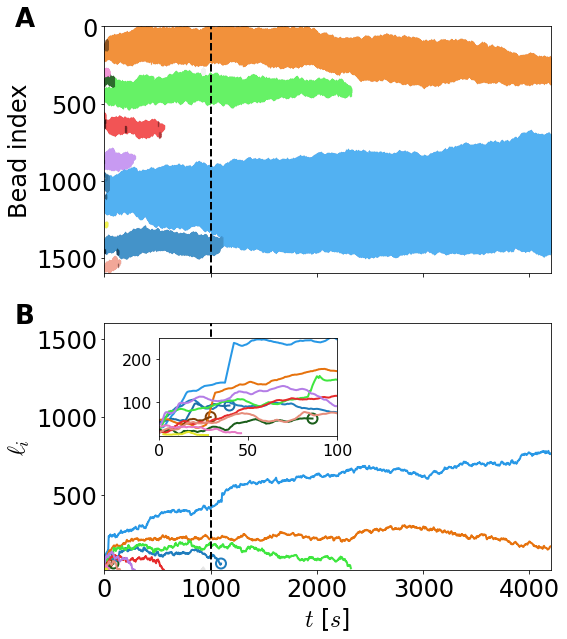

In [6]:
sim_path = ceph_path / "DynCondPaper/24-03-08_aLc1_slice5.5.13_line1600_Pin3-11um_2xKe3-300_ks100/simulations/Ke30_Pin5.0um/s2"

fig, axarr = plt.subplots(2,1, figsize=(8, 10), sharex=True)

# tableau10_colors = iter(cycle(plt.cm.Set1.colors + plt.cm.tab10.colors + plt.cm.Set2.colors + plt.cm.Dark2.colors))
# tableau10_colors = iter(cycle(plt.cm.Dark2.colors))
tableau10_colors = iter(cycle(plt.cm.tab10.colors))
# tableau10_colors = iter(cycle(plt.cm.Set3.colors))

cluster_similarity_threshold = .4 
nskip = 10 # Time snapshot skips for cluster finding. = 10 secs
vmax = 40 # Max colorbar value in kymographs
tree_length = 30 # min length of a cluster tree in time snapshots. = 15 sec
part_min = 40

flat_time_arr = []
flat_clust_cent_arr = []
flat_clust_ind_arr = []

# Length of chain and time to look at
ss_ind = 1
end_ind = None
start_bead = 0
end_bead = None
with h5py.File(next(sim_path.glob('analysis/raw*.h5')), 'r') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    print(time_arr.shape)
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                        :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

    params = yaml.safe_load(h5_data.attrs['RunConfig'])


# Collect data
h5_clust_file = sim_path / 'analysis/cluster_analysis.h5'
with h5py.File(h5_clust_file, 'r') as h5_data:
    cluster_grp = h5_data['clusters']
    time_arr = h5_data['time'][...]
    time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
    clusters = []
    for tg in time_grp_list:
        clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]

# Cluster tree
root_clusters = cla.find_descendants(clusters, thresh=cluster_similarity_threshold, nskip=nskip)

trees = []
tree_id_gen = aa.helpers.gen_id()
for root in root_clusters:
    tree = cla.ClusterTree(next(tree_id_gen))
    tree.add_recursive(root)
    trees += [tree] if len(tree.clusters) > tree_length else []

trees = sorted(trees, key=lambda x: len(x.clusters), reverse=True)


_ = axarr[0].set_ylim(0, 1600)
_ = axarr[0].invert_yaxis()
_ = axarr[0].set_xlim(0, time_arr[-1])
_ = axarr[0].set_ylabel("Bead index")
_ = axarr[1].set_xlabel("$t$ [$s$]")
_ = axarr[1].set_ylabel("$\ell_i$")
_ = axarr[1].set_ylim(20, 1600)
ax_inset = inset_axes(axarr[1], width="40%", height="40%", bbox_to_anchor=(0.1, 0.5, 1, 1), bbox_transform=axarr[1].transAxes, loc='lower left')
_ = ax_inset.set_aspect('auto')
_ = ax_inset.set_xlim(0, 100)
_ = ax_inset.set_ylim(20, 250)
_ = ax_inset.tick_params(axis='both', which='major', labelsize=16)


time_list = []
# for tree, color in zip(trees, tableau10_colors):
for tree in trees:
    # if len(tree.clusters) < tree_length:
    #     continue
    color = next(tableau10_colors)
    branch_roots = tree.get_branch_roots()
    base_color_hsv = mcolors.rgb_to_hsv(color)
    base_color_hsv[2] = .95  
    base_color_hsv[1] *= .8  
    print(base_color_hsv)
    color_step = .8 / len(branch_roots)
    
    for i, root in enumerate(branch_roots):
        branch_clusters = root.get_largest_branch()
        color_hsv = base_color_hsv.copy()
        color_hsv[2] = base_color_hsv[2] - (color_step*i) 
        branch_color = mcolors.hsv_to_rgb(color_hsv)

        for clust in branch_clusters:
            _ = axarr[0].plot([clust.time]*len(clust.part_ids), clust.part_ids, color = branch_color, markersize= .2, marker='.', linestyle='None')

    time_list += plot_branches(axarr[1], time_arr, branch_roots, color=color)
    _ = plot_branches(ax_inset, time_arr, branch_roots, color=color)


# fig.tight_layout()

_ = axarr[0].text(-0.20, 1.00, "A", fontsize=26, transform=axarr[0].transAxes, fontweight='bold')
_ = axarr[1].text(-0.20, 1.00, "B", fontsize=26, transform=axarr[1].transAxes, fontweight='bold')
# _ = axarr[0].text(1.10, 1.00, "C", fontsize=26, transform=axarr[1].transAxes, fontweight='bold')
_ = axarr[0].axvline(x=1000, color='black', linestyle='--', linewidth=2)
_ = axarr[1].axvline(x=1000, color='black', linestyle='--', linewidth=2)

fig.savefig('Figure5/Fig5_tracking.png', dpi=600, bbox_inches='tight')
fig.savefig("/mnt/home/alamson/papers/dyn_cond_paper/images/fig5_tracking.png", dpi=300, bbox_inches="tight")


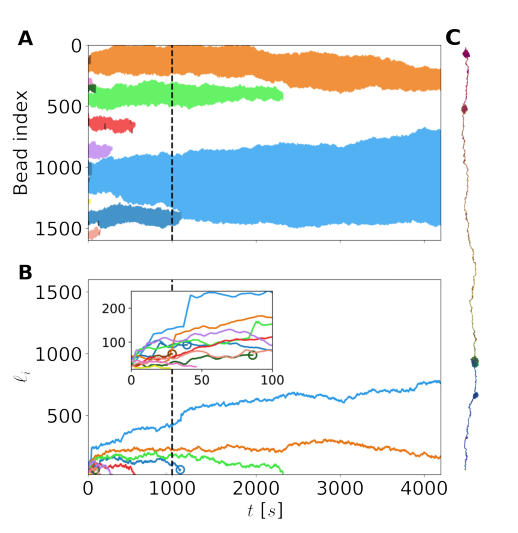

In [19]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.transforms import Affine2D

# Load the image
plot_image_path = "Figure5/Fig5_tracking.png"
plot_img = mpimg.imread(plot_image_path)
snap_image_path = 'Figure5/Ke30_Pin5.0um_s2_2000.png'
snap_img = mpimg.imread(snap_image_path)

# Create a figure
fig = plt.figure(figsize=(8, 10))

# Add a main plot
ax_main = fig.add_subplot(111)
_ = ax_main.imshow(plot_img)
_ = ax_main.axis('off')
# ax_main.set_title('Main Plot')

# Add an inset with the image
rotation = Affine2D().rotate_deg(-90)  # Rotate 45 degrees
aspect_ratio = snap_img.shape[0] / snap_img.shape[1]
ax_inset = fig.add_axes([.8, 0.175, .2, .7])  # [left, bottom, width, height]
_ = ax_inset.imshow(snap_img, transform=rotation + ax_inset.transData, extent=[-snap_img.shape[0]/2, snap_img.shape[0]/2, -snap_img.shape[1]/2, snap_img.shape[1]/2])
_ = ax_inset.set_xlim(-snap_img.shape[0]*.4, snap_img.shape[0]* .4)
_ = ax_inset.set_ylim(-snap_img.shape[1]*.3, snap_img.shape[1]* .3 )
_ = ax_inset.set_aspect('auto')
_ = ax_inset.axis('off')
_ = ax_main.text(.98, .96, "C", fontsize=22, transform=ax_main.transAxes, fontweight='bold')
_ = ax_main.set_zorder(1)

# ax_inset.axis('off')

fig.savefig('Figure5/Fig5_tracking_combined.png', dpi=600, bbox_inches='tight')
fig.savefig("/mnt/home/alamson/papers/dyn_cond_paper/images/fig5_tracking_combined.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

(8401,)
[0.56823266 0.66222222 0.95      ]
Skipping root
Skipping root
[0.07814661 0.75607843 0.95      ]
Skipping root
Skipping root
[0.33333333 0.58       0.95      ]
[0.99904762 0.65420561 0.95      ]
[0.75387597 0.36402116 0.95      ]
[0.02820513 0.37142857 0.95      ]
[0.88425926 0.38061674 0.95      ]
[0.   0.   0.95]
[0.16774194 0.65608466 0.95      ]


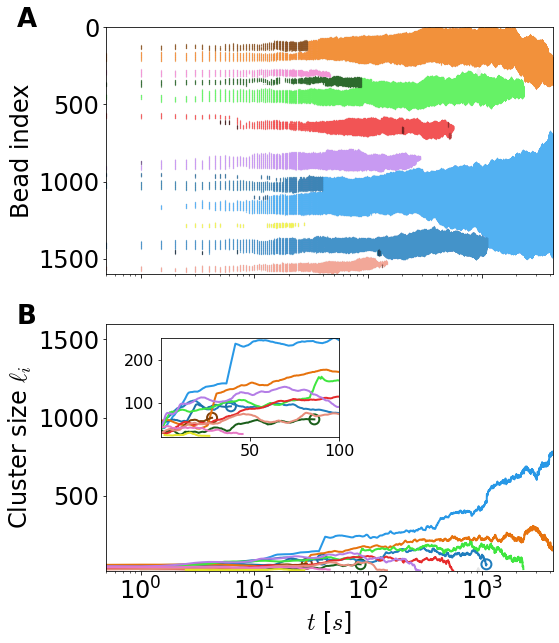

In [31]:
sim_path = ceph_path / "DynCondPaper/24-03-08_aLc1_slice5.5.13_line1600_Pin3-11um_2xKe3-300_ks100/simulations/Ke30_Pin5.0um/s2"

fig, axarr = plt.subplots(2,1, figsize=(8, 10), sharex=True)

# tableau10_colors = iter(cycle(plt.cm.Set1.colors + plt.cm.tab10.colors + plt.cm.Set2.colors + plt.cm.Dark2.colors))
# tableau10_colors = iter(cycle(plt.cm.Dark2.colors))
tableau10_colors = iter(cycle(plt.cm.tab10.colors))
# tableau10_colors = iter(cycle(plt.cm.Set3.colors))

cluster_similarity_threshold = .4 
nskip = 10 # Time snapshot skips for cluster finding. = 10 secs
vmax = 40 # Max colorbar value in kymographs
tree_length = 30 # min length of a cluster tree in time snapshots. = 15 sec
part_min = 40

flat_time_arr = []
flat_clust_cent_arr = []
flat_clust_ind_arr = []

# Length of chain and time to look at
ss_ind = 1
end_ind = None
start_bead = 0
end_bead = None
with h5py.File(next(sim_path.glob('analysis/raw*.h5')), 'r') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    print(time_arr.shape)
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                        :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

    params = yaml.safe_load(h5_data.attrs['RunConfig'])


# Collect data
h5_clust_file = sim_path / 'analysis/cluster_analysis.h5'
with h5py.File(h5_clust_file, 'r') as h5_data:
    cluster_grp = h5_data['clusters']
    time_arr = h5_data['time'][...]
    time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
    clusters = []
    for tg in time_grp_list:
        clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]

# Cluster tree
root_clusters = cla.find_descendants(clusters, thresh=cluster_similarity_threshold, nskip=nskip)

trees = []
tree_id_gen = aa.helpers.gen_id()
for root in root_clusters:
    tree = cla.ClusterTree(next(tree_id_gen))
    tree.add_recursive(root)
    trees += [tree] if len(tree.clusters) > tree_length else []

trees = sorted(trees, key=lambda x: len(x.clusters), reverse=True)


_ = axarr[0].set_ylim(0, 1600)
_ = axarr[0].invert_yaxis()
_ = axarr[0].set_xlim(0.5, time_arr[-1])
_ = axarr[0].set_ylabel("Bead index")
_ = axarr[1].set_xlabel("$t$ [$s$]")
_ = axarr[1].set_ylabel("Cluster size $\ell_i$")
_ = axarr[1].set_ylim(20, 1600)
_ = axarr[1].set_xscale('log')
ax_inset = inset_axes(axarr[1], width="40%", height="40%", bbox_to_anchor=(0.1, 0.5, 1, 1), bbox_transform=axarr[1].transAxes, loc='lower left')
_ = ax_inset.set_aspect('auto')
_ = ax_inset.set_xlim(0.5, 100)
_ = ax_inset.set_ylim(20, 250)
_ = ax_inset.tick_params(axis='both', which='major', labelsize=16)



time_list = []
# for tree, color in zip(trees, tableau10_colors):
for tree in trees:
    # if len(tree.clusters) < tree_length:
    #     continue
    color = next(tableau10_colors)
    branch_roots = tree.get_branch_roots()
    base_color_hsv = mcolors.rgb_to_hsv(color)
    base_color_hsv[2] = .95  
    base_color_hsv[1] *= .8  
    print(base_color_hsv)
    color_step = .8 / len(branch_roots)
    
    for i, root in enumerate(branch_roots):
        branch_clusters = root.get_largest_branch()
        color_hsv = base_color_hsv.copy()
        color_hsv[2] = base_color_hsv[2] - (color_step*i) 
        branch_color = mcolors.hsv_to_rgb(color_hsv)

        for clust in branch_clusters:
            _ = axarr[0].plot([clust.time]*len(clust.part_ids), clust.part_ids, color = branch_color, markersize= .2, marker='.', linestyle='None')

    time_list += plot_branches(axarr[1], time_arr, branch_roots, color=color)
    _ = plot_branches(ax_inset, time_arr, branch_roots, color=color)


# fig.tight_layout()

_ = axarr[0].text(-0.20, 1.00, "A", fontsize=26, transform=axarr[0].transAxes, fontweight='bold')
_ = axarr[1].text(-0.20, 1.00, "B", fontsize=26, transform=axarr[1].transAxes, fontweight='bold')

# fig.savefig('Figure5/Fig5_tracking.png', dpi=600, bbox_inches='tight')
# fig.savefig("/mnt/home/alamson/papers/dyn_cond_paper/images/fig5_tracking.png", dpi=300, bbox_inches="tight")


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


Skipping root
Skipping root


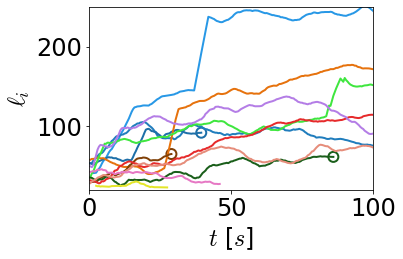

In [6]:
cluster_similarity_threshold = .4 
nskip = 10 # Time snapshot skips for cluster finding. = 10 secs
vmax = 40 # Max colorbar value in kymographs
tree_length = 30 # min length of a cluster tree in time snapshots. = 15 sec
part_min = 40
tableau10_colors = iter(cycle(plt.cm.tab10.colors))
# tableau10_colors = iter(cycle(plt.cm.Set1.colors + plt.cm.tab10.colors + plt.cm.Set2.colors + plt.cm.Dark2.colors))
# tableau10_colors = iter(cycle(plt.cm.Dark2.colors))
# tableau10_colors = iter(cycle(plt.cm.Set3.colors))

data_path = ceph_path / "DynCondPaper/24-03-08_aLc1_slice5.5.13_line1600_Pin3-11um_2xKe3-300_ks100"
sim_path = data_path / "simulations/Ke30_Pin5.0um/s2"

h5_clust_file = sim_path / 'analysis/cluster_analysis.h5'
with h5py.File(h5_clust_file, 'r') as h5_data:
    cluster_grp = h5_data['clusters']
    time_arr = h5_data['time'][...]
    time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
    clusters = []

    for tg in time_grp_list:
        clust_grp = [cla.Cluster(h5_data = c) for c in tg.values()]
        # clust_grp = [clust for clust in clust_grp if len(clust.part_ids) > part_min]
        clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]

# Cluster tree
root_clusters = cla.find_descendants(clusters, thresh=cluster_similarity_threshold, nskip=nskip)

trees = []
tree_id_gen = aa.helpers.gen_id()
for root in root_clusters:
    tree = cla.ClusterTree(next(tree_id_gen))
    tree.add_recursive(root)
    trees += [tree] if len(tree.clusters) > tree_length else []

trees = sorted(trees, key=lambda x: len(x.clusters), reverse=True)

fig, axarr = plt.subplots(1,1, figsize=(6, 4.0))
from scipy.ndimage.filters import uniform_filter1d


merge_events = 0
time_list = []
for tree in trees:
    color = next(tableau10_colors)
    branch_roots = tree.get_branch_roots()
    base_color_hsv = mcolors.rgb_to_hsv(color)
    base_color_hsv[2] = .9  
    base_color_hsv[1] *= .8  
    color_step = .8 / len(branch_roots)

    tree.update_branch_roots()
    branch_roots = tree.get_branch_roots()
    merge_events += len(branch_roots)
    time_list += plot_branches(axarr, time_arr, branch_roots, color=color)

_ = axarr.set_xlabel('$t$ [$s$]')
_ = axarr.set_ylabel('$\ell_i$')
# _ = axarr.set_xscale('log')
# _ = axarr.set_xlim(0.5, 600)
_ = axarr.set_xlim(0, 100)
_ = axarr.set_ylim(20, 250)


fig.tight_layout()
# fig.savefig('Figure3/branch_size_inset.png', dpi=600, bbox_inches='tight')

(8401,)
[0.56823266 0.66222222 0.95      ]
Skipping root
[0.07814661 0.75607843 0.95      ]
Skipping root
[0.33333333 0.58       0.95      ]
[0.99904762 0.65420561 0.95      ]
[0.75387597 0.36402116 0.95      ]
[0.02820513 0.37142857 0.95      ]
[0.88425926 0.38061674 0.95      ]
[0.   0.   0.95]
[0.16774194 0.65608466 0.95      ]


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


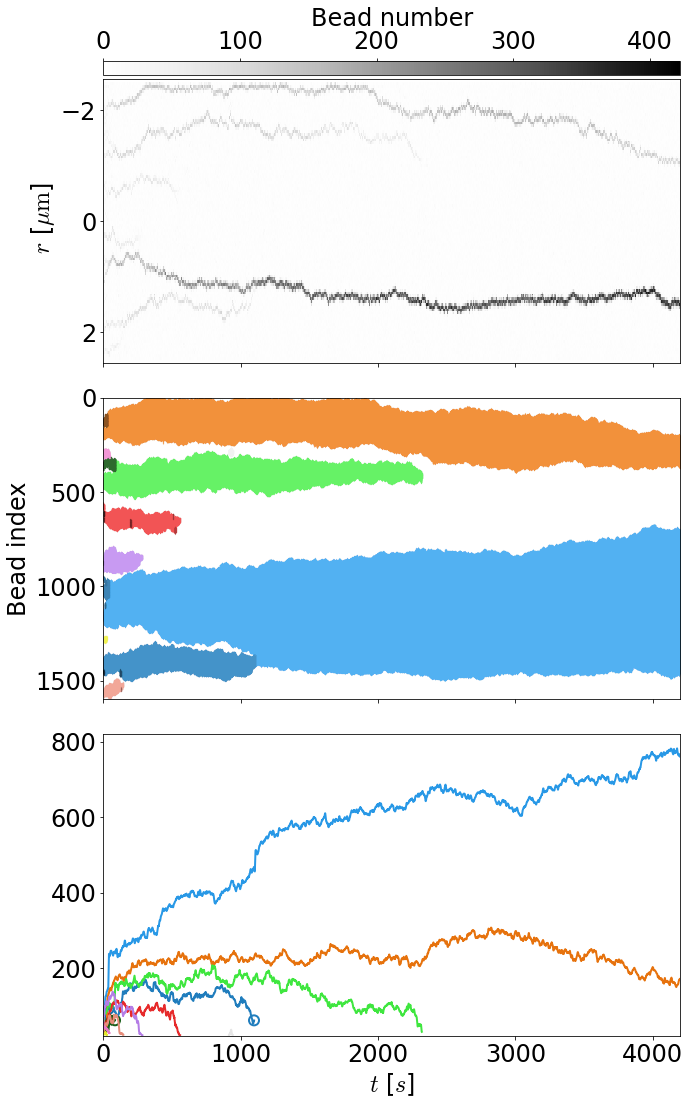

In [ ]:
sim_path = ceph_path / "DynCondPaper/24-03-08_aLc1_slice5.5.13_line1600_Pin3-11um_2xKe3-300_ks100/simulations/Ke30_Pin5.0um/s2"

# tableau10_colors = iter(cycle(plt.cm.Set1.colors + plt.cm.tab10.colors + plt.cm.Set2.colors + plt.cm.Dark2.colors))
# tableau10_colors = iter(cycle(plt.cm.Dark2.colors))
tableau10_colors = iter(cycle(plt.cm.tab10.colors))
# tableau10_colors = iter(cycle(plt.cm.Set3.colors))

cluster_similarity_threshold = .4 
nskip = 10 # Time snapshot skips for cluster finding. = 10 secs
vmax = 40 # Max colorbar value in kymographs
tree_length = 30 # min length of a cluster tree in time snapshots. = 15 sec
part_min = 40

flat_time_arr = []
flat_clust_cent_arr = []
flat_clust_ind_arr = []

# Length of chain and time to look at
ss_ind = 1
end_ind = None
start_bead = 0
end_bead = None
with h5py.File(next(sim_path.glob('analysis/raw*.h5')), 'r') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    print(time_arr.shape)
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                        :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

    params = yaml.safe_load(h5_data.attrs['RunConfig'])

fig, axarr = plt.subplots(3,1, figsize=(10, 15), sharex=True)

# Collect data
h5_clust_file = sim_path / 'analysis/cluster_analysis.h5'
with h5py.File(h5_clust_file, 'r') as h5_data:
    cluster_grp = h5_data['clusters']
    time_arr = h5_data['time'][...]
    time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
    clusters = []
    for tg in time_grp_list:
        clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]

# Kymograph

# Project bead positions onto unit vector from first to last bead
proj_vec = com_arr[-1, :, 0] - com_arr[0, :, 0]
sep_dist = np.linalg.norm(proj_vec)
proj_vec /= sep_dist
proj_arr = np.einsum('ijk,j->ik', com_arr, proj_vec)
# Set range of histograms
range_min = -.51 * sep_dist
range_max = .51 * sep_dist
# Make a series of histograms for each time point
hist_arr = []

for i, proj in enumerate(proj_arr.T):
    hist, bin_edges = np.histogram(proj, bins=100,
                                range=(range_min, range_max))
    hist_arr += [hist]

hist_arr = np.asarray(hist_arr).T
max_color_bar = np.max(hist_arr)
x = np.append(time_arr, [time_arr[-1] + time_arr[2] - time_arr[1]])
X, Y = np.meshgrid(x, bin_edges)

c0 = axarr[0].pcolorfast(X, Y, hist_arr, cmap='Greys')

_ = axarr[0].set_ylabel(r" $r$ [$\mu {\rm m}$]")

_ = axarr[0].invert_yaxis()


# Cluster tree
root_clusters = cla.find_descendants(clusters, thresh=cluster_similarity_threshold, nskip=nskip)

trees = []
tree_id_gen = aa.helpers.gen_id()
for root in root_clusters:
    tree = cla.ClusterTree(next(tree_id_gen))
    tree.add_recursive(root)
    trees += [tree] if len(tree.clusters) > tree_length else []

trees = sorted(trees, key=lambda x: len(x.clusters), reverse=True)


time_list = []
# for tree, color in zip(trees, tableau10_colors):
for tree in trees:
    # if len(tree.clusters) < tree_length:
    #     continue
    color = next(tableau10_colors)
    branch_roots = tree.get_branch_roots()
    base_color_hsv = mcolors.rgb_to_hsv(color)
    base_color_hsv[2] = .95  
    base_color_hsv[1] *= .8  
    print(base_color_hsv)
    color_step = .8 / len(branch_roots)
    
    for i, root in enumerate(branch_roots):
        branch_clusters = root.get_largest_branch()
        color_hsv = base_color_hsv.copy()
        color_hsv[2] = base_color_hsv[2] - (color_step*i) 
        branch_color = mcolors.hsv_to_rgb(color_hsv)

        for clust in branch_clusters:
            _ = axarr[1].plot([clust.time]*len(clust.part_ids), clust.part_ids, color = branch_color, markersize= .2, marker='.', linestyle='None')

    time_list += plot_branches(axarr[2], time_arr, branch_roots, color=color)

_ = axarr[1].set_ylim(0, 1600)
_ = axarr[1].invert_yaxis()
_ = axarr[1].set_xlim(0, time_arr[-1])
_ = axarr[1].set_ylabel("Bead index")
_ = axarr[2].set_xlabel("$t$ [$s$]")
_ = axarr[2].set_ylabel("Cluster size $\ell_i$")
_ = axarr[2].set_ylim(20)



fig.tight_layout()
cax0 = make_axes_locatable(axarr[0]).append_axes("top", size="5%", pad=0.06)

## Side colorbar
# plot1_pos = axarr[0].get_position()
# cb_pos = [plot1_pos.x0+plot1_pos.width + .02, plot1_pos.y0, .025, plot1_pos.height]
# cax1 = fig.add_axes(cb_pos)

cb0 = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=max_color_bar), cmap='Greys'), orientation='horizontal', 
                   cax = cax0, pad=0.1, label='Bead number' )
cb0.ax.xaxis.set_ticks_position('top')
cb0.ax.xaxis.set_label_position('top')

fig.savefig('Figure3/Fig3_combined_r.png', dpi=600, bbox_inches='tight')



(8401,)
[0.56823266 0.66222222 0.95      ]
Skipping root
[0.07814661 0.75607843 0.95      ]
Skipping root
[0.33333333 0.58       0.95      ]
[0.99904762 0.65420561 0.95      ]
[0.75387597 0.36402116 0.95      ]
[0.02820513 0.37142857 0.95      ]
[0.88425926 0.38061674 0.95      ]
[0.   0.   0.95]
[0.16774194 0.65608466 0.95      ]


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


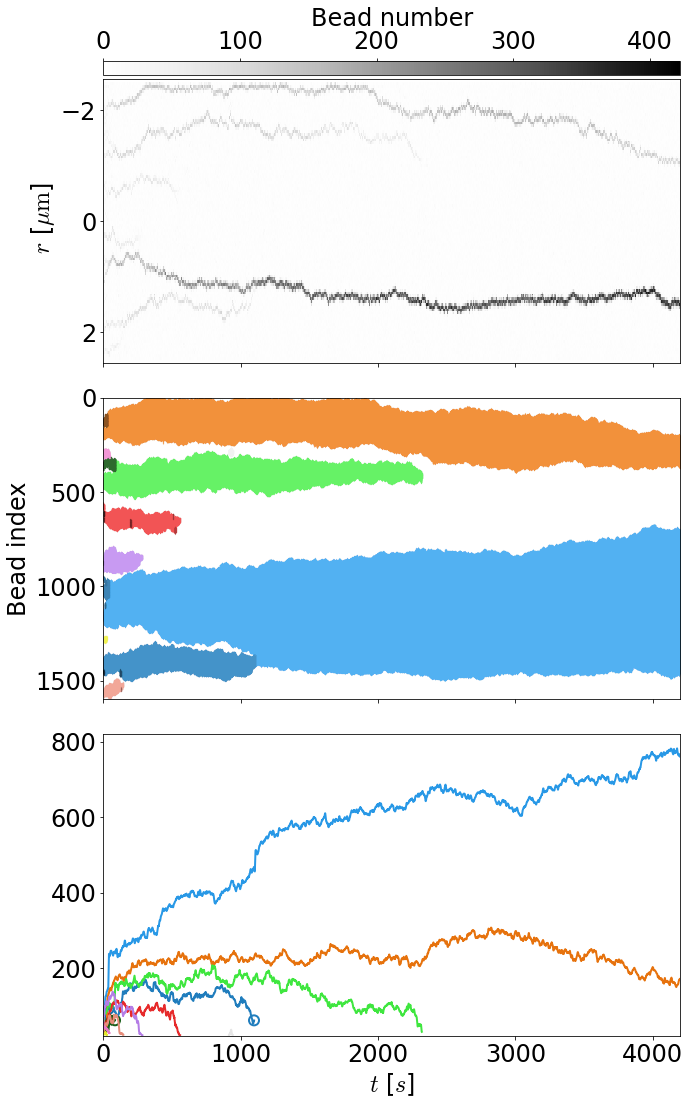

In [ ]:
sim_path = ceph_path / "DynCondPaper/24-03-08_aLc1_slice5.5.13_line1600_Pin3-11um_2xKe3-300_ks100/simulations/Ke30_Pin5.0um/s2"

# tableau10_colors = iter(cycle(plt.cm.Set1.colors + plt.cm.tab10.colors + plt.cm.Set2.colors + plt.cm.Dark2.colors))
# tableau10_colors = iter(cycle(plt.cm.Dark2.colors))
tableau10_colors = iter(cycle(plt.cm.tab10.colors))
# tableau10_colors = iter(cycle(plt.cm.Set3.colors))

cluster_similarity_threshold = .4 
nskip = 10 # Time snapshot skips for cluster finding. = 10 secs
vmax = 40 # Max colorbar value in kymographs
tree_length = 30 # min length of a cluster tree in time snapshots. = 15 sec
part_min = 40

flat_time_arr = []
flat_clust_cent_arr = []
flat_clust_ind_arr = []

# Length of chain and time to look at
ss_ind = 1
end_ind = None
start_bead = 0
end_bead = None
with h5py.File(next(sim_path.glob('analysis/raw*.h5')), 'r') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    print(time_arr.shape)
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                        :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

    params = yaml.safe_load(h5_data.attrs['RunConfig'])

fig, axarr = plt.subplots(3,1, figsize=(10, 15), sharex=True)

# Collect data
h5_clust_file = sim_path / 'analysis/cluster_analysis.h5'
with h5py.File(h5_clust_file, 'r') as h5_data:
    cluster_grp = h5_data['clusters']
    time_arr = h5_data['time'][...]
    time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
    clusters = []
    for tg in time_grp_list:
        clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]

# Kymograph

# Project bead positions onto unit vector from first to last bead
proj_vec = com_arr[-1, :, 0] - com_arr[0, :, 0]
sep_dist = np.linalg.norm(proj_vec)
proj_vec /= sep_dist
proj_arr = np.einsum('ijk,j->ik', com_arr, proj_vec)
# Set range of histograms
range_min = -.51 * sep_dist
range_max = .51 * sep_dist
# Make a series of histograms for each time point
hist_arr = []

for i, proj in enumerate(proj_arr.T):
    hist, bin_edges = np.histogram(proj, bins=100,
                                range=(range_min, range_max))
    hist_arr += [hist]

hist_arr = np.asarray(hist_arr).T
max_color_bar = np.max(hist_arr)
x = np.append(time_arr, [time_arr[-1] + time_arr[2] - time_arr[1]])
X, Y = np.meshgrid(x, bin_edges)

c0 = axarr[0].pcolorfast(X, Y, hist_arr, cmap='Greys')

_ = axarr[0].set_ylabel(r" $r$ [$\mu {\rm m}$]")

_ = axarr[0].invert_yaxis()


# Cluster tree
root_clusters = cla.find_descendants(clusters, thresh=cluster_similarity_threshold, nskip=nskip)

trees = []
tree_id_gen = aa.helpers.gen_id()
for root in root_clusters:
    tree = cla.ClusterTree(next(tree_id_gen))
    tree.add_recursive(root)
    trees += [tree] if len(tree.clusters) > tree_length else []

trees = sorted(trees, key=lambda x: len(x.clusters), reverse=True)


time_list = []
# for tree, color in zip(trees, tableau10_colors):
for tree in trees:
    # if len(tree.clusters) < tree_length:
    #     continue
    color = next(tableau10_colors)
    branch_roots = tree.get_branch_roots()
    base_color_hsv = mcolors.rgb_to_hsv(color)
    base_color_hsv[2] = .95  
    base_color_hsv[1] *= .8  
    print(base_color_hsv)
    color_step = .8 / len(branch_roots)
    
    for i, root in enumerate(branch_roots):
        branch_clusters = root.get_largest_branch()
        color_hsv = base_color_hsv.copy()
        color_hsv[2] = base_color_hsv[2] - (color_step*i) 
        branch_color = mcolors.hsv_to_rgb(color_hsv)

        for clust in branch_clusters:
            _ = axarr[1].plot([clust.time]*len(clust.part_ids), clust.part_ids, color = branch_color, markersize= .2, marker='.', linestyle='None')

    time_list += plot_branches(axarr[2], time_arr, branch_roots, color=color)

_ = axarr[1].set_ylim(0, 1600)
_ = axarr[1].invert_yaxis()
_ = axarr[1].set_xlim(0, time_arr[-1])
_ = axarr[1].set_ylabel("Bead index")
_ = axarr[2].set_xlabel("$t$ [$s$]")
_ = axarr[2].set_ylabel("Cluster size $\ell_i$")
_ = axarr[2].set_ylim(20)



fig.tight_layout()
cax0 = make_axes_locatable(axarr[0]).append_axes("top", size="5%", pad=0.06)

## Side colorbar
# plot1_pos = axarr[0].get_position()
# cb_pos = [plot1_pos.x0+plot1_pos.width + .02, plot1_pos.y0, .025, plot1_pos.height]
# cax1 = fig.add_axes(cb_pos)

cb0 = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=max_color_bar), cmap='Greys'), orientation='horizontal', 
                   cax = cax0, pad=0.1, label='Bead number' )
cb0.ax.xaxis.set_ticks_position('top')
cb0.ax.xaxis.set_label_position('top')

fig.savefig('Figure3/Fig3_combined_r.png', dpi=600, bbox_inches='tight')



# Other images

(3601,)


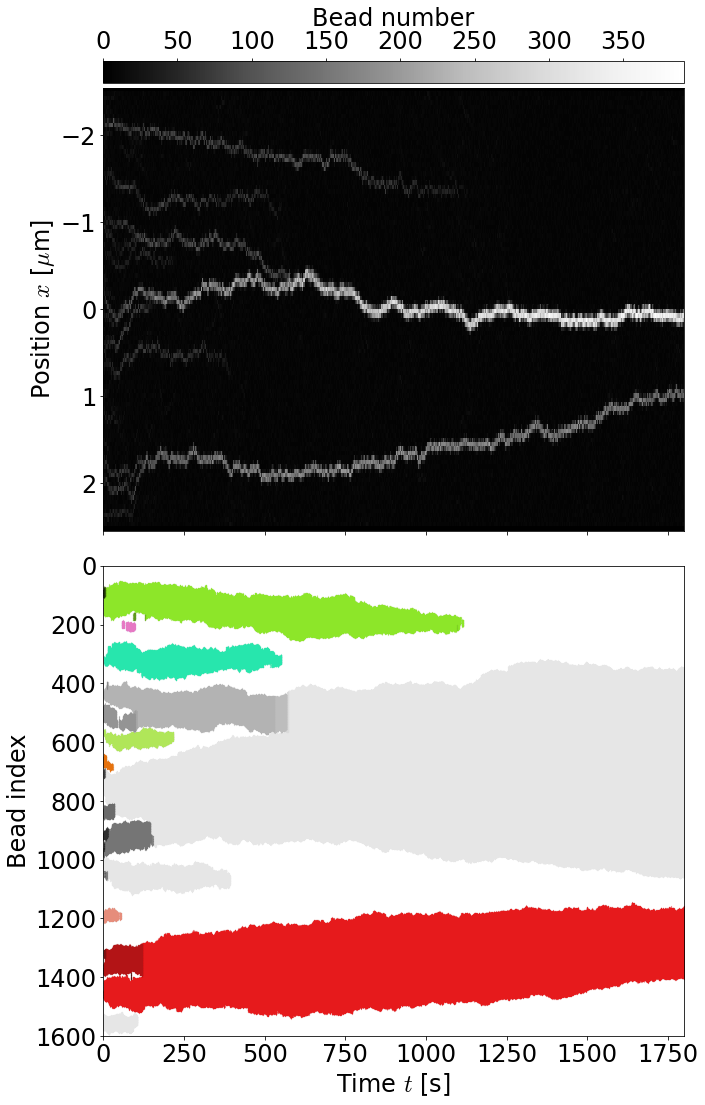

In [13]:
sim_path = ceph_path / "DynCondPaper/24-03-08_aLc1_slice5.5.13_line1600_Pin3-11um_2xKe3-300_ks100/simulations/Ke100_Pin5.0um/s9"

tableau10_colors = iter(cycle(plt.cm.Set1.colors + plt.cm.tab10.colors + plt.cm.Set2.colors + plt.cm.Dark2.colors))
# tableau10_colors = iter(cycle(plt.cm.tab10.colors))

cluster_similarity_threshold = .4 
nskip = 10 # Time snapshot skips for cluster finding. = 10 secs
vmax = 40 # Max colorbar value in kymographs
tree_length = 30 # min length of a cluster tree in time snapshots. = 15 sec
part_min = 40

flat_time_arr = []
flat_clust_cent_arr = []
flat_clust_ind_arr = []

# Length of chain and time to look at
ss_ind = 1
end_ind = None
start_bead = 0
end_bead = None
with h5py.File(next(sim_path.glob('analysis/raw*.h5')), 'r') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    print(time_arr.shape)
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                        :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

    params = yaml.safe_load(h5_data.attrs['RunConfig'])

fig, axarr = plt.subplots(2,1, figsize=(10, 15), sharex=True)

# Collect data
h5_clust_file = sim_path / 'analysis/cluster_analysis.h5'
with h5py.File(h5_clust_file, 'r') as h5_data:
    cluster_grp = h5_data['clusters']
    time_arr = h5_data['time'][...]
    time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
    clusters = []
    for tg in time_grp_list:
        clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]

# Kymograph

# Project bead positions onto unit vector from first to last bead
proj_vec = com_arr[-1, :, 0] - com_arr[0, :, 0]
sep_dist = np.linalg.norm(proj_vec)
proj_vec /= sep_dist
proj_arr = np.einsum('ijk,j->ik', com_arr, proj_vec)
# Set range of histograms
range_min = -.51 * sep_dist
range_max = .51 * sep_dist
# Make a series of histograms for each time point
hist_arr = []

for i, proj in enumerate(proj_arr.T):
    hist, bin_edges = np.histogram(proj, bins=100,
                                range=(range_min, range_max))
    hist_arr += [hist]

hist_arr = np.asarray(hist_arr).T
max_color_bar = np.max(hist_arr)
x = np.append(time_arr, [time_arr[-1] + time_arr[2] - time_arr[1]])
X, Y = np.meshgrid(x, bin_edges)

c0 = axarr[0].pcolorfast(X, Y, hist_arr, cmap='Greys_r')

_ = axarr[0].set_ylabel(r"Position $x$ [$\mu$m]")

_ = axarr[0].invert_yaxis()


# Cluster tree
root_clusters = cla.find_descendants(clusters, thresh=cluster_similarity_threshold, nskip=nskip)

trees = []
tree_id_gen = aa.helpers.gen_id()
for root in root_clusters:
    tree = cla.ClusterTree(next(tree_id_gen))
    tree.add_recursive(root)
    trees += [tree]

for tree, color in zip(trees, tableau10_colors):
    if len(tree.clusters) < tree_length:
        continue
    branch_roots = tree.get_branch_roots()
    base_color_hsv = mcolors.rgb_to_hsv(color)
    base_color_hsv[2] = .9  
    color_step = .8 / len(branch_roots)
    
    for i, root in enumerate(branch_roots):
        branch_clusters = root.get_largest_branch()
        color_hsv = base_color_hsv.copy()
        color_hsv[2] = base_color_hsv[2] - (color_step*i) 
        branch_color = mcolors.hsv_to_rgb(color_hsv)

        for clust in branch_clusters:
            _ = axarr[1].plot([clust.time]*len(clust.part_ids), clust.part_ids, color = branch_color, markersize= .2, marker='.', linestyle='None')

_ = axarr[1].set_ylim(0, 1600)
_ = axarr[1].invert_yaxis()
_ = axarr[1].set_xlim(0, time_arr[-1])
_ = axarr[1].set_ylabel("Bead index")
_ = axarr[1].set_xlabel("Time $t$ [s]")



fig.tight_layout()
cax0 = make_axes_locatable(axarr[0]).append_axes("top", size="5%", pad=0.06)

## Side colorbar
# plot1_pos = axarr[0].get_position()
# cb_pos = [plot1_pos.x0+plot1_pos.width + .02, plot1_pos.y0, .025, plot1_pos.height]
# cax1 = fig.add_axes(cb_pos)

cb0 = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=max_color_bar), cmap='Greys_r'), orientation='horizontal', 
                   cax = cax0, pad=0.1, label='Bead number' )
cb0.ax.xaxis.set_ticks_position('top')
cb0.ax.xaxis.set_label_position('top')

# fig.savefig('Figure3/kymograph_tracking.png', dpi=600, bbox_inches='tight')



(8401,)


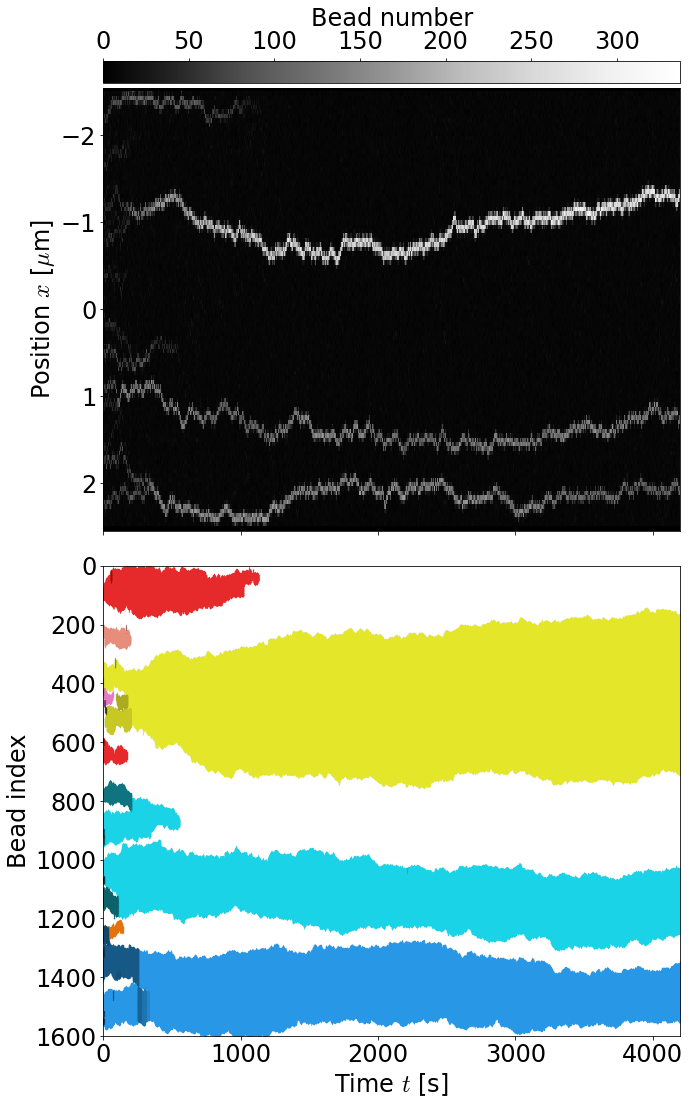

In [29]:
data_path = ceph_path / "DynCondPaper/24-03-08_aLc1_slice5.5.13_line1600_Pin3-11um_2xKe3-300_ks100"
sim_path = data_path / "simulations/Ke100_Pin5.0um/s5"

tableau10_colors = iter(cycle(plt.cm.tab10.colors))

cluster_similarity_threshold = .4 
nskip = 10 # Time snapshot skips for cluster finding. = 10 secs
vmax = 40 # Max colorbar value in kymographs
tree_length = 30 # min length of a cluster tree in time snapshots. = 15 sec
part_min = 40

flat_time_arr = []
flat_clust_cent_arr = []
flat_clust_ind_arr = []

# Length of chain and time to look at
ss_ind = 1
end_ind = None
start_bead = 0
end_bead = None
with h5py.File(next(sim_path.glob('analysis/raw*.h5')), 'r') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    print(time_arr.shape)
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                        :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

    params = yaml.safe_load(h5_data.attrs['RunConfig'])

fig, axarr = plt.subplots(2,1, figsize=(10, 15), sharex=True)

# Collect data
h5_clust_file = sim_path / 'analysis/cluster_analysis.h5'
with h5py.File(h5_clust_file, 'r') as h5_data:
    cluster_grp = h5_data['clusters']
    time_arr = h5_data['time'][...]
    time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
    clusters = []
    for tg in time_grp_list:
        clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]

# Kymograph

# Project bead positions onto unit vector from first to last bead
proj_vec = com_arr[-1, :, 0] - com_arr[0, :, 0]
sep_dist = np.linalg.norm(proj_vec)
proj_vec /= sep_dist
proj_arr = np.einsum('ijk,j->ik', com_arr, proj_vec)
# Set range of histograms
range_min = -.51 * sep_dist
range_max = .51 * sep_dist
# Make a series of histograms for each time point
hist_arr = []

for i, proj in enumerate(proj_arr.T):
    hist, bin_edges = np.histogram(proj, bins=100,
                                range=(range_min, range_max))
    hist_arr += [hist]

hist_arr = np.asarray(hist_arr).T
max_color_bar = np.max(hist_arr)
x = np.append(time_arr, [time_arr[-1] + time_arr[2] - time_arr[1]])
X, Y = np.meshgrid(x, bin_edges)

c0 = axarr[0].pcolorfast(X, Y, hist_arr, cmap='Greys_r')

_ = axarr[0].set_ylabel(r"Position $x$ [$\mu$m]")

_ = axarr[0].invert_yaxis()


# Cluster tree
root_clusters = cla.find_descendants(clusters, thresh=cluster_similarity_threshold, nskip=nskip)

trees = []
tree_id_gen = aa.helpers.gen_id()
for root in root_clusters:
    tree = cla.ClusterTree(next(tree_id_gen))
    tree.add_recursive(root)
    trees += [tree]

for tree, color in zip(trees, tableau10_colors):
    if len(tree.clusters) < tree_length:
        continue
    branch_roots = tree.get_branch_roots()
    base_color_hsv = mcolors.rgb_to_hsv(color)
    base_color_hsv[2] = .9  
    color_step = .8 / len(branch_roots)
    
    for i, root in enumerate(branch_roots):
        branch_clusters = root.get_largest_branch()
        color_hsv = base_color_hsv.copy()
        color_hsv[2] = base_color_hsv[2] - (color_step*i) 
        branch_color = mcolors.hsv_to_rgb(color_hsv)

        for clust in branch_clusters:
            _ = axarr[1].plot([clust.time]*len(clust.part_ids), clust.part_ids, color = branch_color, markersize= .2, marker='.', linestyle='None')

_ = axarr[1].set_ylim(0, 1600)
_ = axarr[1].invert_yaxis()
_ = axarr[1].set_xlim(0, time_arr[-1])
_ = axarr[1].set_ylabel("Bead index")
_ = axarr[1].set_xlabel("Time $t$ [s]")



fig.tight_layout()
cax0 = make_axes_locatable(axarr[0]).append_axes("top", size="5%", pad=0.06)

## Side colorbar
# plot1_pos = axarr[0].get_position()
# cb_pos = [plot1_pos.x0+plot1_pos.width + .02, plot1_pos.y0, .025, plot1_pos.height]
# cax1 = fig.add_axes(cb_pos)

cb0 = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=max_color_bar), cmap='Greys_r'), orientation='horizontal', 
                   cax = cax0, pad=0.1, label='Bead number' )
cb0.ax.xaxis.set_ticks_position('top')
cb0.ax.xaxis.set_label_position('top')

# fig.savefig('Figure3/kymograph_tracking.png', dpi=600, bbox_inches='tight')



(1201,)


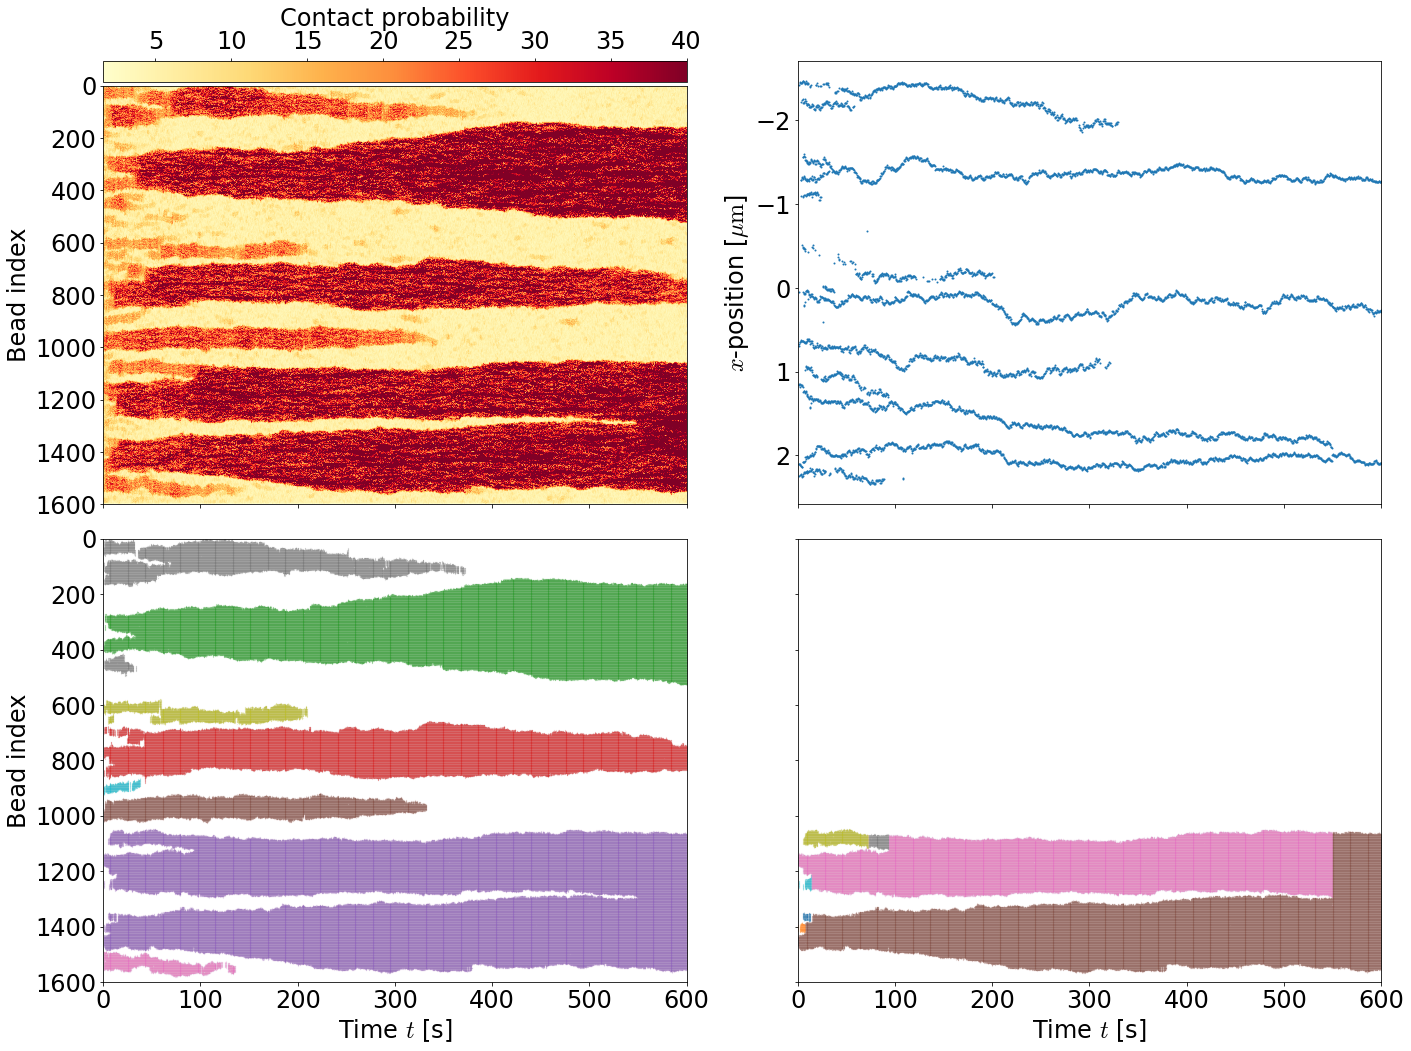

In [48]:
data_path = ceph_path / "DynCondPaper/23-10-20_aLc1_slice8.7._line1600_Pin1-13um_2xKe.1-300_ks100"
sim_path = data_path / "simulations/Ke100_Pin5.0um/"

tableau10_colors = iter(cycle(plt.cm.tab10.colors))

cluster_similarity_threshold = .4 
nskip = 10 # Time snapshot skips for cluster finding. = 10 secs
vmax = 40 # Max colorbar value in kymographs
tree_length = 30 # min length of a cluster tree in time snapshots. = 15 sec
part_min = 40

flat_time_arr = []
flat_clust_cent_arr = []
flat_clust_ind_arr = []

# Length of chain and time to look at
ss_ind = 1
end_ind = None
start_bead = 0
end_bead = None
with h5py.File(next(sim_path.glob('analysis/raw*.h5')), 'r') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    print(time_arr.shape)
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                        :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

fig, axarr = plt.subplots(2,2, figsize=(20, 15), sharex=True)

# Kymograph
h5_contact_file = sim_path / 'analysis/contact_analysis.h5'
with h5py.File(h5_contact_file, 'r') as h5_data:
    time_arr = h5_data['time'][...]
    contact_kymo = h5_data['contact_kymo'][...]

    plot_contact_kymo(fig, axarr[0,0], time_arr, contact_kymo, vmax=vmax)
    _ = axarr[0,0].set_ylim(0, 1600)
    _ = axarr[0,0].invert_yaxis()


h5_clust_file = sim_path / 'analysis/cluster_analysis.h5'
with h5py.File(h5_clust_file, 'r') as h5_data:
    cluster_grp = h5_data['clusters']
    time_arr = h5_data['time'][...]
    time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
    clusters = []
    for tg in time_grp_list:
        clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]

# Cluster position
bead_ind_arr = np.zeros((com_arr.shape[0], com_arr.shape[2]))
one_mask = np.ones(com_arr.shape[0])
for c, clust_grp in enumerate(clusters):
    # Secondary thresholding
    clust_grp = [clust for clust in clust_grp if len(clust.part_ids) > part_min]
    num_beads = 0
    for i, clust in enumerate(clust_grp):
        flat_time_arr += [clust.time]
        flat_clust_cent_arr += [clust.center]
        flat_clust_ind_arr += [clust.part_ids]
        bead_ind_arr[clust.part_ids,c] += one_mask[clust.part_ids]

flat_clust_cent_arr = np.asarray(flat_clust_cent_arr)
_ = axarr[0,1].invert_yaxis()
_ = axarr[0,1].plot(flat_time_arr, flat_clust_cent_arr[:,0], '.' )
_ = axarr[0,1].set_ylabel(r'$x$-position [$\mu {\rm m}$]')

# Cluster tree
root_clusters = cla.find_descendants(clusters, thresh=cluster_similarity_threshold, nskip=nskip)

trees = []
tree_id_gen = aa.helpers.gen_id()
for root in root_clusters:
    tree = cla.ClusterTree(next(tree_id_gen))
    tree.add_recursive(root)
    trees += [tree]


# Graph all clusters
for tree, color in zip(trees, tableau10_colors):
    if len(tree.clusters) < tree_length:
        continue
    for clust in tree.clusters:
        _ = axarr[1,0].plot([clust.time]*len(clust.part_ids), clust.part_ids, color = color, markersize= .1, marker='.', linestyle='None')

# Graph largest branch
biggest_tree = max(trees, key=lambda x: x.get_main_clust_branch()[0].mass_hist)
biggest_tree.update_branch_roots()
branch_roots = biggest_tree.get_branch_roots()

for root, color in zip(branch_roots, tableau10_colors):
    branch_clusters = root.get_largest_branch()
    for clust in branch_clusters:
        _ = axarr[1,1].plot([clust.time]*len(clust.part_ids), clust.part_ids, color = color, markersize= .1, marker='.', linestyle='None')

_ = axarr[1,0].set_ylabel("Bead index")
_ = axarr[1,1].set_yticklabels([])
for ax in axarr[1,:]:
    _ = ax.set_ylim(0, 1600)
    _ = ax.invert_yaxis()
    _ = ax.set_xlim(0, time_arr[-1])
    _ = ax.set_xlabel("Time $t$ [s]")


fig.tight_layout()



(1201,)


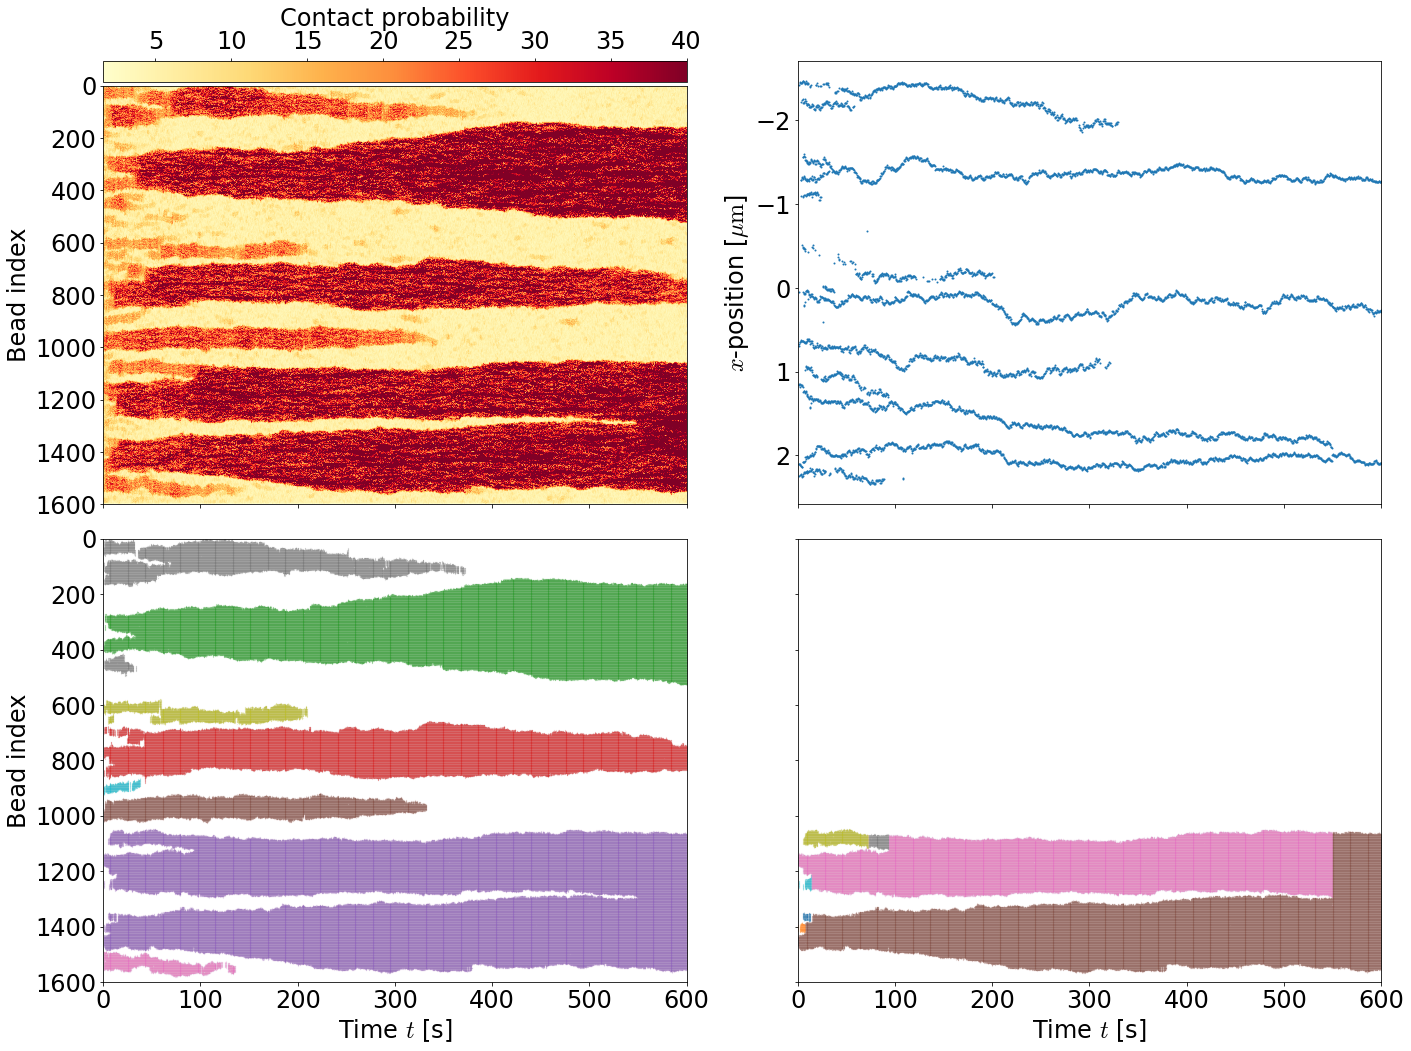

In [ ]:
data_path = ceph_path / "DynCondPaper/23-10-20_aLc1_slice8.7._line1600_Pin1-13um_2xKe.1-300_ks100"
sim_path = data_path / "simulations/Ke100_Pin5.0um/"

tableau10_colors = iter(cycle(plt.cm.tab10.colors))

cluster_similarity_threshold = .4 
nskip = 10 # Time snapshot skips for cluster finding. = 10 secs
vmax = 40 # Max colorbar value in kymographs
tree_length = 30 # min length of a cluster tree in time snapshots. = 15 sec
part_min = 40

flat_time_arr = []
flat_clust_cent_arr = []
flat_clust_ind_arr = []

# Length of chain and time to look at
ss_ind = 1
end_ind = None
start_bead = 0
end_bead = None
with h5py.File(next(sim_path.glob('analysis/raw*.h5')), 'r') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    print(time_arr.shape)
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                        :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

fig, axarr = plt.subplots(2,2, figsize=(20, 15), sharex=True)

# Kymograph
h5_contact_file = sim_path / 'analysis/contact_analysis.h5'
with h5py.File(h5_contact_file, 'r') as h5_data:
    time_arr = h5_data['time'][...]
    contact_kymo = h5_data['contact_kymo'][...]

    plot_contact_kymo(fig, axarr[0,0], time_arr, contact_kymo, vmax=vmax)
    _ = axarr[0,0].set_ylim(0, 1600)
    _ = axarr[0,0].invert_yaxis()


h5_clust_file = sim_path / 'analysis/cluster_analysis.h5'
with h5py.File(h5_clust_file, 'r') as h5_data:
    cluster_grp = h5_data['clusters']
    time_arr = h5_data['time'][...]
    time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
    clusters = []
    for tg in time_grp_list:
        clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]

# Cluster position
bead_ind_arr = np.zeros((com_arr.shape[0], com_arr.shape[2]))
one_mask = np.ones(com_arr.shape[0])
for c, clust_grp in enumerate(clusters):
    # Secondary thresholding
    clust_grp = [clust for clust in clust_grp if len(clust.part_ids) > part_min]
    num_beads = 0
    for i, clust in enumerate(clust_grp):
        flat_time_arr += [clust.time]
        flat_clust_cent_arr += [clust.center]
        flat_clust_ind_arr += [clust.part_ids]
        bead_ind_arr[clust.part_ids,c] += one_mask[clust.part_ids]

flat_clust_cent_arr = np.asarray(flat_clust_cent_arr)
_ = axarr[0,1].invert_yaxis()
_ = axarr[0,1].plot(flat_time_arr, flat_clust_cent_arr[:,0], '.' )
_ = axarr[0,1].set_ylabel(r'$x$-position [$\mu {\rm m}$]')

# Cluster tree
root_clusters = cla.find_descendants(clusters, thresh=cluster_similarity_threshold, nskip=nskip)

trees = []
tree_id_gen = aa.helpers.gen_id()
for root in root_clusters:
    tree = cla.ClusterTree(next(tree_id_gen))
    tree.add_recursive(root)
    trees += [tree]


# Graph all clusters
for tree, color in zip(trees, tableau10_colors):
    if len(tree.clusters) < tree_length:
        continue
    for clust in tree.clusters:
        _ = axarr[1,0].plot([clust.time]*len(clust.part_ids), clust.part_ids, color = color, markersize= .1, marker='.', linestyle='None')

# Graph largest branch
biggest_tree = max(trees, key=lambda x: x.get_main_clust_branch()[0].mass_hist)
biggest_tree.update_branch_roots()
branch_roots = biggest_tree.get_branch_roots()

for root, color in zip(branch_roots, tableau10_colors):
    branch_clusters = root.get_largest_branch()
    for clust in branch_clusters:
        _ = axarr[1,1].plot([clust.time]*len(clust.part_ids), clust.part_ids, color = color, markersize= .1, marker='.', linestyle='None')

_ = axarr[1,0].set_ylabel("Bead index")
_ = axarr[1,1].set_yticklabels([])
for ax in axarr[1,:]:
    _ = ax.set_ylim(0, 1600)
    _ = ax.invert_yaxis()
    _ = ax.set_xlim(0, time_arr[-1])
    _ = ax.set_xlabel("Time $t$ [s]")


fig.tight_layout()

